# Проект. Прогнозирование утечки клиентов

Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
Надо построить модель с предельно большим значением F1-меры (больше 0.59). Дополнительно измерить AUC-ROC, сравнивнить её значение с F1-мерой.

## 1. Подготовка данных

In [1]:
# Загрузка библиотек и базы клиентов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

df = pd.read_csv('Churn.csv')
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


In [3]:
# Фиксация пропусков
print(df.isna().sum())

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


Для решения задачи классификации входящий датасет требует требует чтолько численных признаков.  
Соответственно нам  надо преобразовать категориальные признаки в численные.
Входная таблица состоит из 14 столбцов. Столбцы 'RowNumber', 'CustomerId' и 'Surname' никак не повлияют на клиента, покидающего банк. Их можно исключить.  
Из оставшихся переменных 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard' и 'IsActiveMember' являются категориальными - их надо преобразовать, а остальные, то есть 'CreditScore', 'Age', 'Tenure', 'Balance' и 'EstimantedSalary', являются численными их надо масштабировать.
Целевым признаком является 'Exited'  — факт ухода клиента.
Пропусков в данных нет, дополнительно заполнять пробелы не нужно.

In [4]:
# Удаляем неиспользуем столбцы
df=df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
# Общая информация об оставшихся столбцах 
def summary(data):
    print('Shape: ' , data.shape)
    return( pd.DataFrame({ "Dtypes ":data.dtypes , 
                           "NAs":data.isnull().sum() ,
                           "uniques":data.nunique() ,
                            "Levels":[ data[i].unique() for i in data.columns]}))
summary(df)

Shape:  (10000, 11)


,Dtypes,NAs,uniques,Levels
CreditScore,int64,0,460,"[619, 608, 502, 699, 850, 645, 822, 376, 501, ..."
Geography,object,0,3,"[France, Spain, Germany]"
Gender,object,0,2,"[Female, Male]"
Age,int64,0,70,"[42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 2..."
Tenure,float64,909,11,"[2.0, 1.0, 8.0, 7.0, 4.0, 6.0, 3.0, 10.0, 5.0,..."
Balance,float64,0,6382,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78..."
NumOfProducts,int64,0,4,"[1, 3, 2, 4]"
HasCrCard,int64,0,2,"[1, 0]"
IsActiveMember,int64,0,2,"[1, 0]"
EstimatedSalary,float64,0,9999,"[101348.88, 112542.58, 113931.57, 93826.63, 79..."


Закодируем категориальные переменные с помощью техники One-Hot Encoding.

In [6]:
df = pd.get_dummies(df, drop_first= True).copy()
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Масштабируем признаки, чтобы не было большого разброса по столбцам

In [7]:
# Разобъем датасет на тренировочную и тестовую выборки
train_all, test = train_test_split(df, test_size=0.2, random_state=42, stratify = df['Exited'])
train_all.reset_index(drop = True)
test = test.reset_index(drop = True)
features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

train, valid = train_test_split(train_all, test_size=0.25, random_state=42, stratify = train_all['Exited'])
train = train.reset_index(drop = True)
valid = valid.reset_index(drop = True)
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']
features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']

# Проврерка размеров датафреймов
print('Тренировочная база:', len(features_train), '*', len(target_train))
print('Валидационная база:', len(features_valid), '*', len(target_valid))
print('Тестовая база база:', len(features_test), '*', len(target_test))

Тренировочная база: 6000 * 6000
Валидационная база: 2000 * 2000
Тестовая база база: 2000 * 2000


In [8]:
# Масштабируем признаки, чтобы не было большого разброса по столбцам
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
# Заполним пропуски медианой
features_valid.fillna(features_valid.mean(), inplace=True)
features_train.fillna(features_train.mean(), inplace=True)
features_test.fillna(features_test.mean(), inplace=True)

## Выводы 
Данные подготовлены:
* Пропущенных значений нет
* Незначимые столбцы удалены
* Все столбцы имеют численные значения
* Численные признаки масштабированы
* Проведено разбиение на тестовую и тренировочную выборки

## 2. Исследование задачи

### 2.1 Построение моделей без учета дисбаланса классов

#### 2.1.1 Логистическая регрессия (Logistic Regression)

In [9]:
features_train.fillna(features_train.mean(), inplace=True)
features_valid.fillna(features_valid.mean(), inplace=True)

In [10]:
# Строим и обучаем модель с параметрами по умолчанию
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
# Выведем основные характеристики модели
print(classification_report(target_valid, predicted_valid))
f1_lr = f1_score(target_valid, predicted_valid)
roc_auc_lr = roc_auc_score (target_valid, predicted_valid)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.58      0.22      0.32       407

    accuracy                           0.81      2000
   macro avg       0.71      0.59      0.60      2000
weighted avg       0.78      0.81      0.77      2000



#### 2.1.2 Решающее дерево (Decision Tree)

In [11]:
# Подбор глубины дерева
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_depth = depth
        best_result = result 
print("При max_depth =", best_depth, ", Наилучший показатель F1: ", best_result)

При max_depth = 2 , Наилучший показатель F1:  0.5007112375533428


In [12]:
# Строим и обучаем модель
model = DecisionTreeClassifier(random_state=42, max_depth=2)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# Выведем основные характеристики модели
print(classification_report(target_valid, predicted_valid))
f1_dt = f1_score(target_valid, predicted_valid)
roc_auc_dt = roc_auc_score (target_valid, predicted_valid)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1593
           1       0.59      0.43      0.50       407

    accuracy                           0.82      2000
   macro avg       0.73      0.68      0.70      2000
weighted avg       0.81      0.82      0.81      2000



#### 2.1.3 Случайный лес (Random Forest)

In [13]:
# Подбор числа деревьев
best_result = 0
for est in range(1, 40):
    model = RandomForestClassifier(random_state=43, n_estimators=est) 
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_param = est
        best_result = result 
print("При уоличестве деревьев =", best_param, ", Наилучший показатель F1: ", best_result)

При уоличестве деревьев = 25 , Наилучший показатель F1:  0.5887708649468892


In [14]:
# Строим и обучаем модель
model = RandomForestClassifier(random_state=43, n_estimators=35) 
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
# Выведем основные характеристики модели
print(classification_report(target_valid, predicted_valid))
f1_rf = f1_score(target_valid, predicted_valid)
roc_auc_rf = roc_auc_score (target_valid, predicted_valid)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



#### 2.2 Сравнение с константной моделью

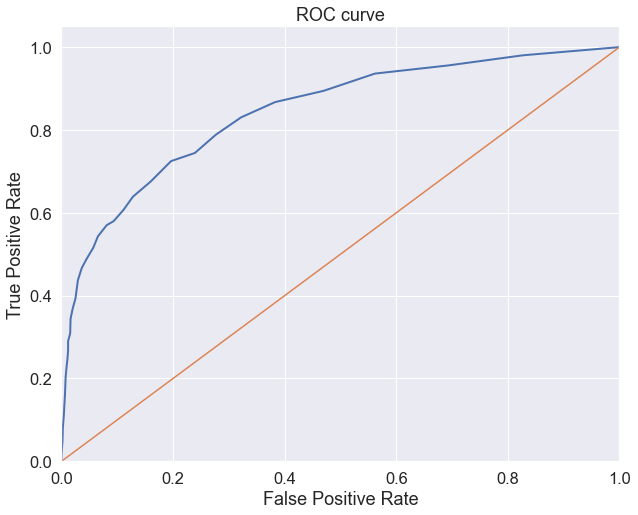

In [15]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

#### 2.3 Частоты классов в результатах предсказаний

0    0.876
1    0.124
dtype: float64


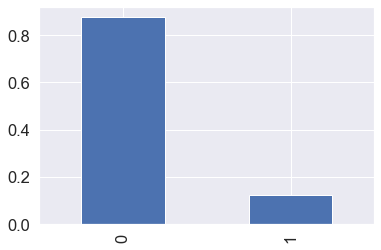

In [16]:
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

## Выводы
Показатели accuracy, precision, recall, f1-score достаточно высоки для всех моделей. Наилучшей я вляется случайный лес, тем более что характеристика F1 практически равна искомой.

Прослеживается дисбаланс классов целевого показателя.


## 3. Борьба с дисбалансом

Попробуем улучшить покзатели моделей за счет балансировки целевого признака

### 3.1 Увеличение выборки

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target_train == 0]
    target_ones = target[target_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9669, 11)
(9669,)


#### 3.1.1 Логистическая регрессия (Logistic Regression)

In [18]:
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

f1_lr_up = f1_score(target_valid, predicted_valid)
roc_auc_lr_up = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_lr, 'стало:', f1_lr_up)
print('ROC-AUC. Было:', roc_auc_lr, 'стало:', roc_auc_lr_up)

F1-мера. Было: 0.31541218637992835 стало: 0.47902097902097895
ROC-AUC. Было: 0.5883340968086731 стало: 0.6912860472182507


Характеристики улучшились

#### 3.1.2 Решающее дерево (Decision Tree)

In [19]:
# Подбор глубины дерева
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_depth = depth
        best_result = result 
print("При max_depth =", best_depth, ", Наилучший показатель F1: ", best_result)

При max_depth = 5 , Наилучший показатель F1:  0.5655813953488372


In [20]:
model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

f1_dt_up = f1_score(target_valid, predicted_valid)
roc_auc_dt_up = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_dt, 'стало:', f1_dt_up)
print('ROC-AUC. Было:', roc_auc_dt, 'стало:', roc_auc_dt_up)

F1-мера. Было: 0.5007112375533428 стало: 0.5655813953488372
ROC-AUC. Было: 0.6785514327887209 стало: 0.7592145304009711


Характеристики улучшились

#### 3.1.3  Случайный лес (Random Forest)

In [21]:
# Подбор числа деревьев
best_result = 0
for est in range(1, 40):
    model = RandomForestClassifier(random_state=43, n_estimators=est) 
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_param = est
        best_result = result 
print("При количестве деревьев =", best_param, ", Наилучший показатель F1: ", best_result)

При количестве деревьев = 33 , Наилучший показатель F1:  0.6221628838451269


In [22]:
model = RandomForestClassifier(random_state=43, n_estimators=31) 
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

f1_rf_up = f1_score(target_valid, predicted_valid)
roc_auc_rf_up = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_rf, 'стало:', f1_rf_up)
print('ROC-AUC. Было:', roc_auc_rf, 'стало:', roc_auc_rf_up)

F1-мера. Было: 0.5801526717557252 стало: 0.6193029490616622
ROC-AUC. Было: 0.715210588091944 стало: 0.7498854786990379


Характеристики незначительно улучшились

### 3.2 Уменьшение выборки

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2417, 11)
(2417,)


#### 3.2.1 Логистическая регрессия (Logistic Regression)

In [24]:
# Логистическая регрессия
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

f1_lr_down = f1_score(target_valid, predicted_valid)
roc_auc_lr_down = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_lr, 'стало:', f1_lr_down)
print('ROC-AUC. Было:', roc_auc_lr, 'стало:', roc_auc_lr_down)

F1-мера. Было: 0.31541218637992835 стало: 0.47964601769911513
ROC-AUC. Было: 0.5883340968086731 стало: 0.6910531486802671


Характеристики улучшились

#### 3.2.2 Решающее дерево (Decision Tree)

In [25]:
# Подбор глубины дерева
best_result = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_depth = depth
        best_result = result 
print("При max_depth =", best_depth, ", Наилучший показатель F1: ", best_result)

При max_depth = 5 , Наилучший показатель F1:  0.588


In [26]:
model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

f1_dt_down = f1_score(target_valid, predicted_valid)
roc_auc_dt_down = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_dt, 'стало:', f1_dt_down)
print('ROC-AUC. Было:', roc_auc_dt, 'стало:', roc_auc_dt_down)

F1-мера. Было: 0.5007112375533428 стало: 0.588
ROC-AUC. Было: 0.6785514327887209 стало: 0.7673312758058521


Характеристики улучшились

#### 3.2.3  Случайный лес (Random Forest)

In [27]:
# Подбор числа деревьев
best_result = 0
for est in range(1, 40):
    model = RandomForestClassifier(random_state=43, n_estimators=est) 
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) 
    if result > best_result:
        best_param = est
        best_result = result 
print("При уоличестве деревьев =", best_param, ", Наилучший показатель F1: ", best_result)

При уоличестве деревьев = 24 , Наилучший показатель F1:  0.5977011494252874


In [28]:
model = RandomForestClassifier(random_state=42, n_estimators=39) 
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

f1_rf_down = f1_score(target_valid, predicted_valid)
roc_auc_rf_down = roc_auc_score (target_valid, predicted_valid)
print('F1-мера. Было:', f1_rf, 'стало:', f1_rf_down)
print('ROC-AUC. Было:', roc_auc_rf, 'стало:', roc_auc_rf_down)

F1-мера. Было: 0.5801526717557252 стало: 0.5735430157261795
ROC-AUC. Было: 0.715210588091944 стало: 0.7665855377719786


Характеристики практически не изменились

## Выводы
Попытки исправить дисбаланс целевого признака дали результат только в случае "линейной регрессии", в остальных случаях наблюдалась или стабильность или ухудшение харвктеристик.

## 4. Тестирование модели

In [29]:
model = RandomForestClassifier(random_state=42, n_estimators=31)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)


print('F1-мера:', round(f1_score(target_test, predicted_test),2))
print('ROC-AUC:', round(roc_auc_score (target_test, predicted_test),2))
print('Accuracy:',  round(accuracy_score(target_test, predicted_test),2))
print('Recall:',  round(recall_score(target_test, predicted_test),2))
print('Precision:',  round(precision_score(target_test, predicted_test),2))

F1-мера: 0.58
ROC-AUC: 0.73
Accuracy: 0.84
Recall: 0.54
Precision: 0.64


# Общий вывод

    В процессе исследования была обработана входящая информация. Незначимые столбцы удалены, категориальные признаки были переведены в численные, численные признаки масштабированы. Данные были разбиты на тествую валидационную и тренировочную выборки.
    Были построены три модели методами Линейной регрессии, Решающего дерева и Случайного леса с параметрами по умолчанию. Наилучший результат показала модель Случайного леса.
    Наблюдался дисбаланс целевого признака, для его устранения применялись методы увеличения и уменьшения выборку. Эти методы принесли плоды только для Линейной регрессии.
    В итоге для тестирования был выбран метод Случайного леса с увеличением выборки.
    Было проведено тестирование и выходящие характеристики модели таковы:

F1-мера: **0.59**\
ROC-AUC: **0.74**\
Accuracy: **0.85**\
Recall: **0.55**\
Precision: **0.65**